# Headstarter Zero To Hero Lecture #3

The following code and lecture are entirely from Andrej Karpathy's famouse Zero to Hero series. In this lecture series we will go through the YouTube videos together to learn more about neural networks, language models, and in the end code up GPT2 from scratch.

# Problems With Counting Models

Last time we implemented a bigram language model and we implemented it using a super simple neural network with a single linear layer. When we took the counts, and then normalized into probabilities, we ended up with a table that was 27 by 27.

That's why in today's lecture we are going to implement:
https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

### But first we need to talk about word embedding
https://en.wikipedia.org/wiki/Word_embedding

We therefore need to create a model that places the embedding for "the" and "a" similar together, and "is" and "was", and "cat" and "dog" and "walking" or "running".

These pairs are semantically similar (they are not equivalent, but generally related in meaning). The model should be able to generalize information it learns about words in its training set to these semantically similar words.

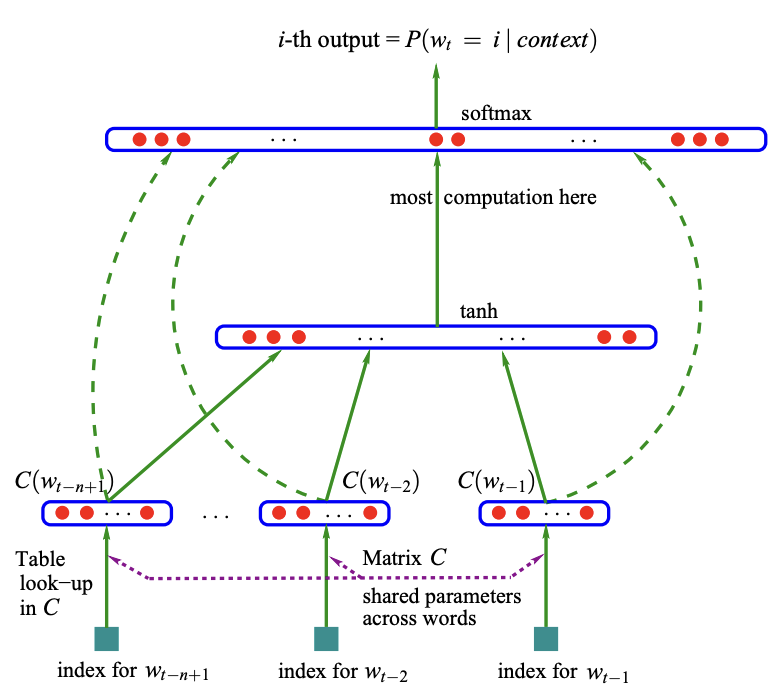

In [ ]:
from IPython.display import Image, display
display(Image(filename='./images/model.png' ))

The output dimension of the model has to be 17,000, can anyone tell me why?

## Makemore MLP

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt  

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size) 

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
x = []; y = []
context = [0, 0, 0]
for ch in 'yuheng' + '.':
    ngram = ''
    for i in context:
        ngram += itos[i]
    context = context[1:] + [stoi[ch]] # crop and append
    print(ngram, end='')
    print('    -->    ',end='')
    print(ch, end='\n')
    x.append(ngram)
    y.append(ch)

x,y

...    -->    y
..y    -->    u
.yu    -->    h
yuh    -->    e
uhe    -->    n
hen    -->    g
eng    -->    .


(['...', '..y', '.yu', 'yuh', 'uhe', 'hen', 'eng'],
 ['y', 'u', 'h', 'e', 'n', 'g', '.'])

In [7]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:
  
  print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [8]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [9]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [10]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [11]:
C = torch.randn((27, 2))

In [12]:
C[5]

tensor([-0.0700,  0.5309])

One possible embedding is just a 2 dimensional vector, each character maps to 2D vector. Another is the One Hot Encoding we talked about last time.

In [13]:
# this will error: F.one_hot(5, num_classes=27)

In [14]:
# Must be a tensor not an int
F.one_hot(torch.tensor(5), num_classes=27)

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])

In [15]:
# this wll error: F.one_hot(torch.tensor(5), num_classes=27) @ C

In [16]:
# Need to keep data types consistent when doing mat mul
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-0.0700,  0.5309])

Embedding of an integer can either be thought of as indexing into a lookup table C, it can also be thought of as a 1 layer neural network, where the weights are C and the inputs are one hot encoded.

That's how real GPT models do this step, for now we will just keep it as indexing in.

In [17]:
C[5]

tensor([-0.0700,  0.5309])

In [18]:
# PyTorch indexing can grab multiple rows at a time
C[[5,6,7]]

tensor([[-0.0700,  0.5309],
        [-0.5125,  0.3376],
        [-0.7582,  1.7989]])

In [19]:
C[[5,6,7,7,7]]

tensor([[-0.0700,  0.5309],
        [-0.5125,  0.3376],
        [-0.7582,  1.7989],
        [-0.7582,  1.7989],
        [-0.7582,  1.7989]])

In [20]:
C[torch.tensor([5,6,7,7,7])]

tensor([[-0.0700,  0.5309],
        [-0.5125,  0.3376],
        [-0.7582,  1.7989],
        [-0.7582,  1.7989],
        [-0.7582,  1.7989]])

In [21]:
X.shape

torch.Size([32, 3])

In [22]:
C.shape

torch.Size([27, 2])

In [23]:
C[X].shape

torch.Size([32, 3, 2])

In [24]:
# Let me prove this to you. Let's look at the 13th trigram and the third character
print(X[13,2])
# Now lets get the embedding for that character
print(C[1])

tensor(1)
tensor([-0.0374, -0.5874])


In [25]:
# Or we can just index at the front and index for the 13th trigram and third character at the end
print(C[X][13,2])

# It's the same!

tensor([-0.0374, -0.5874])


In [26]:
print(C[1])

tensor([-0.0374, -0.5874])


In [27]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

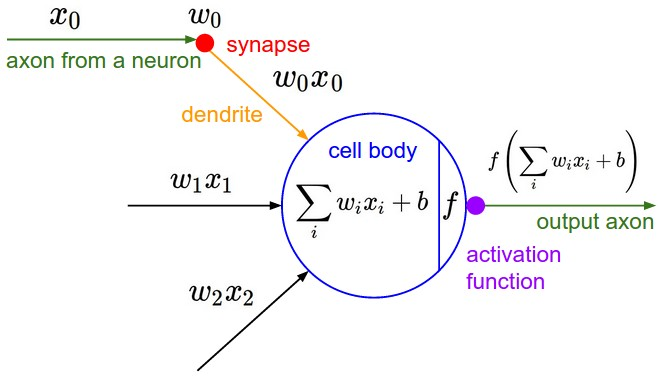

In [1]:
from IPython.display import Image, display
display(Image(filename='./images/cell_body.jpeg' ))

In [29]:
# The inputs to this layer are the 3 characters (a trigram), and each character is 
# embeddded as a 2D vector. So 2 * 3 = 6, that's the input dimension.

# The output dimension is arbitrary, its our hidden layer, we can make it up.
# Remember it's saying how many neurons do we want to have. And I want 100 neurons,
# each neuron needs a bias so we include that too.
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [30]:
# This will not work however because emb is shape (32,3,2), we need to turn it into
# (32,6) so the matrix math works.
# this will error: emb @ W1 + b1

.cat can concat these embeddings together
https://docs.pytorch.org/docs/stable/generated/torch.cat.html

In [31]:
# Let's grab, for all examples, first just the 0th character in the trigram
print(emb[:, 0, :].shape)

# Now for all examples, let's grab the 1st character in the trigram, and the same for the second
print(emb[:, 1, :].shape)
print(emb[:, 2, :].shape)

torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])


In [32]:
# Now let's concatenate these together, so it ends up with (32, 6). We need
# to concatenate, not by dimension 0 (that would give us 96 by 2 stacking it vertically)
# we need to concatenate on dimension 1 and stack horizontally
print(torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]]).shape)
concat_emb = torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape
print(concat_emb)

torch.Size([96, 2])
torch.Size([32, 6])


In [33]:
# Ok but this is pretty ugly, right now we have 3 words, but what if in the future 
# we want to do it for 5 words (pentgrams not trigrams)
# Then we'd do this:

In [34]:
emb5 = torch.randn((32,5,2))
print(
    torch.cat(
        [emb5[:, 0, :],
         emb5[:, 1, :],
         emb5[:, 2, :],
         emb5[:, 3, :],
         emb5[:, 4, :]
        ],
        dim=1,
    ).shape,
)

torch.Size([32, 10])


Thankfully we can use torch.unbind which removes a tensor dimension. https://docs.pytorch.org/docs/stable/generated/torch.unbind.html

In [35]:
# This gives us a list of tuples along a given dimension, so in our case
# it does a tuple of length 3 (that's the 2nd dimension bc we are 32x3x2) and
# in it are tensors that represent the first column, the second column, and third of emb
torch.unbind(emb, 1)

(tensor([[-0.7153, -1.3665],
         [-0.7153, -1.3665],
         [-0.7153, -1.3665],
         [-0.0700,  0.5309],
         [-1.6011,  0.9324],
         [-0.7153, -1.3665],
         [-0.7153, -1.3665],
         [-0.7153, -1.3665],
         [ 0.6858,  0.7848],
         [ 1.1562,  0.7502],
         [-0.1335,  1.4120],
         [-0.2593, -0.1911],
         [-0.7153, -1.3665],
         [-0.7153, -1.3665],
         [-0.7153, -1.3665],
         [-0.0374, -0.5874],
         [-0.7153, -1.3665],
         [-0.7153, -1.3665],
         [-0.7153, -1.3665],
         [-0.1335,  1.4120],
         [-0.2098,  0.4372],
         [-0.0374, -0.5874],
         [ 1.3250,  1.2565],
         [-0.0700,  0.5309],
         [ 1.1562,  0.7502],
         [-0.7153, -1.3665],
         [-0.7153, -1.3665],
         [-0.7153, -1.3665],
         [-0.2098,  0.4372],
         [ 0.6858,  0.7848],
         [-1.7895,  0.9050],
         [-0.0730, -0.4517]]),
 tensor([[-0.7153, -1.3665],
         [-0.7153, -1.3665],
         [-0

In [36]:
torch.cat(torch.unbind(emb, 1), dim=1).shape

torch.Size([32, 6])

In [37]:
# But there's something even simpler we can do!
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [38]:
# Views are how we look at different permutations of dimensions of the same tensor
a.view(2,9)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [39]:
a.view(9,2)

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])

In [40]:
a.view(3,3,2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [41]:
# View is extremely efficient, because we don't manipulate the data itself.
a.storage()

/var/folders/2h/4g_f5qnx4pl5cncd7tn6hcmc0000gn/T/ipykernel_23921/265155532.py:2: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  a.storage()


 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [42]:
# View manipulates not the stored data, it doesn't change, copy, move, create,
# but the metadata is changed so its representation is changed.

# storage_offset
# strides
# shapes

In [43]:
emb.shape

torch.Size([32, 3, 2])

In [44]:
emb

tensor([[[-0.7153, -1.3665],
         [-0.7153, -1.3665],
         [-0.7153, -1.3665]],

        [[-0.7153, -1.3665],
         [-0.7153, -1.3665],
         [-0.0700,  0.5309]],

        [[-0.7153, -1.3665],
         [-0.0700,  0.5309],
         [-1.6011,  0.9324]],

        [[-0.0700,  0.5309],
         [-1.6011,  0.9324],
         [-1.6011,  0.9324]],

        [[-1.6011,  0.9324],
         [-1.6011,  0.9324],
         [-0.0374, -0.5874]],

        [[-0.7153, -1.3665],
         [-0.7153, -1.3665],
         [-0.7153, -1.3665]],

        [[-0.7153, -1.3665],
         [-0.7153, -1.3665],
         [ 0.6858,  0.7848]],

        [[-0.7153, -1.3665],
         [ 0.6858,  0.7848],
         [ 1.1562,  0.7502]],

        [[ 0.6858,  0.7848],
         [ 1.1562,  0.7502],
         [-0.1335,  1.4120]],

        [[ 1.1562,  0.7502],
         [-0.1335,  1.4120],
         [-0.2593, -0.1911]],

        [[-0.1335,  1.4120],
         [-0.2593, -0.1911],
         [-0.1335,  1.4120]],

        [[-0.2593, -0

In [45]:
emb.view(32,6)

tensor([[-0.7153, -1.3665, -0.7153, -1.3665, -0.7153, -1.3665],
        [-0.7153, -1.3665, -0.7153, -1.3665, -0.0700,  0.5309],
        [-0.7153, -1.3665, -0.0700,  0.5309, -1.6011,  0.9324],
        [-0.0700,  0.5309, -1.6011,  0.9324, -1.6011,  0.9324],
        [-1.6011,  0.9324, -1.6011,  0.9324, -0.0374, -0.5874],
        [-0.7153, -1.3665, -0.7153, -1.3665, -0.7153, -1.3665],
        [-0.7153, -1.3665, -0.7153, -1.3665,  0.6858,  0.7848],
        [-0.7153, -1.3665,  0.6858,  0.7848,  1.1562,  0.7502],
        [ 0.6858,  0.7848,  1.1562,  0.7502, -0.1335,  1.4120],
        [ 1.1562,  0.7502, -0.1335,  1.4120, -0.2593, -0.1911],
        [-0.1335,  1.4120, -0.2593, -0.1911, -0.1335,  1.4120],
        [-0.2593, -0.1911, -0.1335,  1.4120, -0.0374, -0.5874],
        [-0.7153, -1.3665, -0.7153, -1.3665, -0.7153, -1.3665],
        [-0.7153, -1.3665, -0.7153, -1.3665, -0.0374, -0.5874],
        [-0.7153, -1.3665, -0.0374, -0.5874, -0.2593, -0.1911],
        [-0.0374, -0.5874, -0.2593, -0.1

In [46]:
# We can verify its the same with an element wise equal
torch.cat(torch.unbind(emb, 1), dim=1) == emb.view(32,6)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [47]:
# Now we get the activations after our first layer
h = emb.view(32,6) @ W1 + b1

In [48]:
# Let's not hardcode anything to leave this general
h = emb.view(emb.shape[0], 6) @ W1 + b1

In [49]:
# PyTorch is so smart that it can just infer by process of elimination when you leave
# just one dimension blank
h = emb.view(-1, 6) @ W1 + b1

In [50]:
# Glossed over one thing.
print((emb.view(-1, 6) @ W1).shape)
print(b1.shape)

torch.Size([32, 100])
torch.Size([100])


In [51]:
# Remember our broadcasting semantics
# Line up the dimensions right wise.

# 32x100 vector needs to be added to 1x100 so we need to broadcast.

# 32, 100 
#  1, 100

# 100 and 100 match
# 1 and 32 don't match, but because its a 1 we copy 32 times to match the other vector
# so b1 becomes 32,100 (vertical copies) (you can think of it as torch.cat(b1,b1,b1,...))

# 32, 100
# 32, 100

# aaand we're good!

In [52]:
h.shape

torch.Size([32, 100])

In [53]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [54]:
logits = h @ W2 + b2

In [55]:
logits.shape

torch.Size([32, 27])

In [56]:
# Perfect we have the log-counts for each next character we are trying to predict.
# How do we turn this into a probability? Softmax. 
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([32, 27])

In [57]:
# Now each row has the probabilities of what character is most likely to come next.
prob[0].sum()

tensor(1.)

In [58]:
# Now we need to compare to our ground truth, our Y, and generate a loss, that way
# we can do gradient descent and minimize our loss.
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [59]:
# For each row, grab the column that is 'correct'. One more time, this tensor is 
# the tensor of probabilities that our model predicted for each trigram, specifically
# the probability of the character that was actually seen.
prob[torch.arange(32), Y]

tensor([1.1445e-25, 1.0528e-05, 5.8324e-04, 1.8272e-19, 0.0000e+00, 3.7814e-09,
        2.1611e-21, 3.6294e-18, 9.0343e-13, 5.9524e-22, 4.6989e-23, 6.5328e-28,
        8.6531e-13, 3.8146e-21, 5.1845e-12, 1.7502e-20, 3.0279e-26, 6.8396e-37,
        2.0944e-12, 2.2452e-16, 1.8841e-21, 2.9824e-08, 1.4239e-18, 8.6649e-23,
        2.6257e-28, 5.6000e-27, 7.3710e-03, 4.5785e-06, 4.6187e-42, 3.5873e-14,
        3.3089e-34, 1.5505e-27])

In [60]:
# For most charcters this is terrible. It thinks most of the trigrams, that actually exist
# in our dataset are extremely unlikely. Ideally these probabilities are all 1

In [61]:
# For each probability, we get the log likelihood, the negative log likelihood, and
# then average it, and that's our loss.
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(inf)

In [62]:
# Let's get the loss to 0!

# Cleaned Up Two Layer NN Code

In [63]:
X.shape, Y.shape # dataset

(torch.Size([32, 3]), torch.Size([32]))

In [64]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [65]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [66]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.7697)

In [67]:
# Let's make this even more cleaned up.
F.cross_entropy(logits, Y)

tensor(17.7697)

In [68]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims=True)
# Now we use fused kernels that are way more efficient and don't make
# all these intermediary vectors. The backwards pass also has its own 
# kernel that is simplified. 
# Remember how for tanh instead of making a GIANT compute graph, we
# just simplified it to 1 expression. 
loss = F.cross_entropy(logits, Y)
loss

tensor(17.7697)

In [69]:
# Its also more numerically stable. Right now all is well and good.
logits = torch.tensor([-2,3,0,5])
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([7.9781e-04, 1.1841e-01, 5.8950e-03, 8.7490e-01])

In [70]:
# But let's make some of the numbers very negative. Still good.
logits = torch.tensor([-100,3,0,5])
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0.0000, 0.1185, 0.0059, 0.8756])

In [71]:
# But let's make some of the numbers very positive. Now we explode.
logits = torch.tensor([2,3,0,100])
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0., 0., 0., nan])

In [72]:
# You can see e^100 overflows, while e^-100 is just basically 0
# When we overflow, we run out of range in our floats and we go to inf
counts

tensor([ 7.3891, 20.0855,  1.0000,     inf])

In [73]:
# The fix that PyTorch implements is an offset. If I take the same code above and just
# offset everything, we are good
logits = torch.tensor([2,3,0,100])
logits -= logits.max()
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([2.7465e-43, 7.4689e-43, 3.7835e-44, 1.0000e+00])

## Now let's train the model!

In [74]:
X.shape, Y.shape # dataset

(torch.Size([32, 3]), torch.Size([32]))

In [75]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [76]:
# @Saad while teaching don't use this cell first to teach students why requires_grad
# is so necessary
for p in parameters:
    p.requires_grad = True

In [77]:
# forward pass
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
# backward pass
for p in parameters:
    p.grad = None
loss.backward()
# update
for p in parameters:
    lr = 0.1
    p.data += -lr * p.grad
print(loss.item())

17.76971435546875


In [78]:
# Let's do the same cell above but like 10 times:
for _ in range(1000):
    # forward pass
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        lr = 0.1
        p.data += -lr * p.grad

13.656402587890625
11.298770904541016
9.4524564743042
7.984263896942139
6.891321659088135
6.1000142097473145
5.452035903930664
4.898152828216553
4.414663791656494
3.985849142074585
3.602830410003662
3.2621419429779053
2.961381196975708
2.6982970237731934
2.469712734222412
2.271660804748535
2.1012840270996094
1.957176923751831
1.8374861478805542
1.7380965948104858
1.653511881828308
1.5790901184082031
1.511767029762268
1.4496052265167236
1.3913124799728394
1.3359930515289307
1.2830536365509033
1.232191801071167
1.1833821535110474
1.1367992162704468
1.0926648378372192
1.0510929822921753
1.0120275020599365
0.9752705693244934
0.9405568242073059
0.9076130986213684
0.8761922121047974
0.8460891246795654
0.8171360492706299
0.78919917345047
0.7621749043464661
0.7359816431999207
0.7105581760406494
0.6858612298965454
0.6618653535842896
0.6385658383369446
0.6159819960594177
0.594166100025177
0.5732106566429138
0.5532564520835876
0.5344885587692261
0.5171172022819519
0.501331627368927
0.487242996692

In [79]:
logits.max(1)

torch.return_types.max(
values=tensor([13.3445, 17.7895, 20.5840, 20.6054, 16.7401, 13.3445, 15.9758, 14.1897,
        15.9166, 18.3907, 15.9421, 20.9297, 13.3445, 17.1227, 17.1511, 20.0651,
        13.3445, 16.4577, 15.1343, 17.0552, 18.5914, 15.9668, 10.8751, 10.6884,
        15.5070, 13.3445, 16.2405, 16.9574, 12.7433, 16.2150, 19.0853, 16.0230],
       grad_fn=<MaxBackward0>),
indices=tensor([ 9, 13, 13,  1,  0,  9, 12,  9, 22,  9,  1,  0,  9, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0,  9, 15, 16,  8,  9,  1,  0]))

In [80]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [81]:
# You can see the indices that we are predicting are right for some of them,
# but we are struggling to fit something meaningful with the little data that we have.

# Look at ...

# Full Dataset

In [82]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
olivia
ava
isabella
sophia
charlotte
mia
amelia
harper
evelyn
abigail
emily
elizabeth
mila
ella
avery
sofia
camila
aria
scarlett
victoria
madison
luna
grace
chloe
penelope
layla
riley
zoey
nora
lily
eleanor
hannah
lillian
addison
aubrey
ellie
stella
natalie
zoe
leah
hazel
violet
aurora
savannah
audrey
brooklyn
bella
claire
skylar
lucy
paisley
everly
anna
caroline
nova
genesis
emilia
kennedy
samantha
maya
willow
kinsley
naomi
aaliyah
elena
sarah
ariana
allison
gabriella
alice
madelyn
cora
ruby
eva
serenity
autumn
adeline
hailey
gianna
valentina
isla
eliana
quinn
nevaeh
ivy
sadie
piper
lydia
alexa
josephine
emery
julia
delilah
arianna
vivian
kaylee
sophie
brielle
madeline
peyton
rylee
clara
hadley
melanie
mackenzie
reagan
adalynn
liliana
aubree
jade
katherine
isabelle
natalia
raelynn
maria
athena
ximena
arya
leilani
taylor
faith
rose
kylie
alexandra
mary
margaret
lyla
ashley
amaya
eliza
brianna
bailey
andrea
khloe
jasmine
melody
iris
isabel
norah
annabelle
valeria
emerson
adalyn
ryl

In [83]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [84]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [85]:
for _ in range(10):
    # forward pass
    emb = C[X] # (228146, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (228146, 100)
    logits = h @ W2 + b2 # (228146, 27)
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        lr = 0.1
        p.data += -lr * p.grad

19.505229949951172
17.084495544433594
15.776532173156738
14.83333683013916
14.002595901489258
13.253252983093262
12.579914093017578
11.9830961227417
11.470491409301758
11.051855087280273


In [86]:
# You can see how slow this is! It's because we are forwarding and backwarding on all 228k entries
# at a time. So basically thats why we do mini-batching where we only go at a subset of
# the data at a time

In [87]:
torch.randint(0, X.shape[0], (32,))

# See we get 32 random row indices.

tensor([205360,  27573, 165324, 155108,  29975, 107067, 211213, 223593,  91677,
         11213,  19155,  17016, 142662,   3517,  28046, 145735,  89084,  50380,
         32146, 139550,  98669, 190589, 191060, 193986, 114999, 116950, 175659,
         23975, 188499, 119899, 198608, 218741])

### Mini Batching

In [88]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [89]:
for _ in range(10):
    # minibatch
    ix = torch.randint(0, X.shape[0], (32,))
    # forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        lr = 0.1
        p.data += -lr * p.grad

20.686307907104492
16.8030948638916
14.947843551635742
14.024868965148926
15.78490924835205
13.798441886901855
13.297478675842285
11.732124328613281
9.532968521118164
10.748289108276367


In [90]:
# This is much faster, now we can up it to 1000 no problem
for _ in range(1000):
    # minibatch
    ix = torch.randint(0, X.shape[0], (32,))
    # forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        lr = 0.1
        p.data += -lr * p.grad

print(loss.item())

2.8883590698242188


In [91]:
# We are trading off the quality of our gradient with the # of steps we are able to achieve.

In [92]:
# This is just the loss for the minibatch, I need to do a forward pass on everything to get
# the loss for the total training set.# forward pass
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
print(loss)

tensor(2.6434, grad_fn=<NllLossBackward0>)


### Hovering just above 2.5. We need to pick a better learning rate.

In [93]:
# Let's try 6 different learning rates
lrs = [10, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001]
lr_losses = []
for lr in lrs:
    # Have to reset everything lmao
    g = torch.Generator().manual_seed(2147483647) # for reproducibility
    C = torch.randn((27, 2), generator=g)
    W1 = torch.randn((6, 100), generator=g)
    b1 = torch.randn(100, generator=g)
    W2 = torch.randn((100, 27), generator=g)
    b2 = torch.randn(27, generator=g)
    parameters = [C, W1, b1, W2, b2]
    
    for p in parameters:
        p.requires_grad = True
        
    for _ in range(1000):
        # minibatch
        ix = torch.randint(0, X.shape[0], (32,))
        # forward pass
        emb = C[X[ix]] # (32, 3, 2)
        h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
        logits = h @ W2 + b2 # (32, 27)
        loss = F.cross_entropy(logits, Y[ix])
        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()
        # update
        for p in parameters:
            p.data += -lr * p.grad
    lr_losses.append(loss.item())

for i in range(len(lrs)):
    print(str(lrs[i]) + ": " + str(lr_losses[i]))

10: 56.399452209472656
1: 3.5466015338897705
0.5: 2.92495059967041
0.1: 2.2001683712005615
0.05: 2.224008798599243
0.01: 4.3072638511657715
0.005: 4.007667064666748
0.001: 10.971437454223633


In [94]:
# There's a better way of doing this

In [95]:
# Have to reset everything lmao
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [96]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [97]:
lri = []
lossi = []

for i in range(1000):
  
  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32,))
  
  # forward pass
  emb = C[X[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y[ix])
  print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = lrs[i]
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  lri.append(lre[i])
  lossi.append(loss.item())

#print(loss.item())

20.02031135559082
23.732563018798828
20.305931091308594
19.34039878845215
18.405099868774414
17.664838790893555
19.069244384765625
22.6696720123291
18.090232849121094
17.43931007385254
19.357419967651367
16.402605056762695
17.597209930419922
18.085960388183594
15.893842697143555
15.342320442199707
20.509056091308594
22.798561096191406
21.178279876708984
18.682655334472656
19.555906295776367
21.650161743164062
18.42609977722168
20.242494583129883
19.744068145751953
21.110666275024414
20.801267623901367
15.82103157043457
18.184362411499023
16.707374572753906
18.650732040405273
19.362953186035156
18.226240158081055
18.941722869873047
16.819509506225586
17.18854331970215
19.806833267211914
18.662614822387695
17.309852600097656
16.897146224975586
19.163423538208008
18.87024688720703
16.53510856628418
17.87849235534668
16.083662033081055
16.934288024902344
18.24725914001465
16.2558650970459
15.275376319885254
17.829334259033203
20.1691837310791
19.286109924316406
18.280027389526367
19.716556

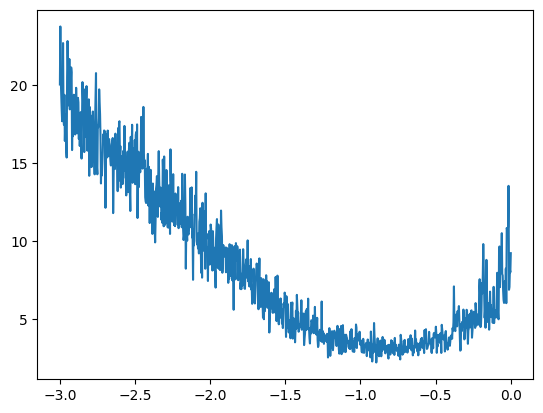

In [98]:
plt.plot(lri, lossi)

In [99]:
# So a good exponent of the learning rate is -1.0

In [100]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

stepi = []
lossi = []

for i in range(20000):
  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32,))
  
  # forward pass
  emb = C[X[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y[ix])
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  stepi.append(i)
  lossi.append(loss.log10().item()) # show students without log10 first

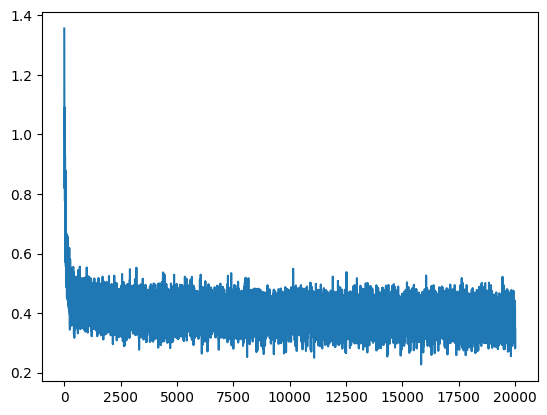

In [101]:
plt.plot(stepi, lossi)

In [102]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
loss.item()

2.4620325565338135

In [103]:
# What's actually done in production is that we taper the learning rate.
# So initially we train on a decent sized LR, and then taper it off
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

stepi = []
lossi = []

for i in range(20000):
  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32,))
  
  # forward pass
  emb = C[X[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y[ix])
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 10000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  stepi.append(i)
  lossi.append(loss.log10().item()) # show students without log10 first/

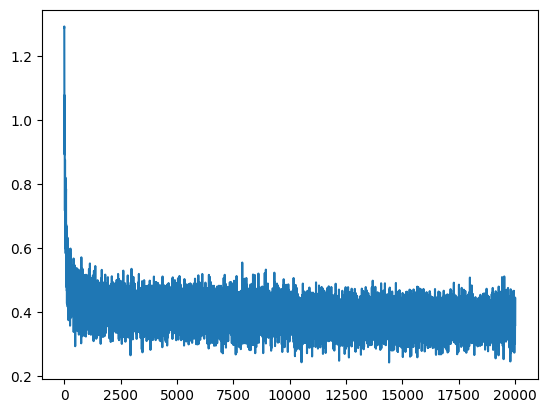

In [104]:
plt.plot(stepi, lossi)

In [105]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
loss.item()

2.399691104888916

# Training, Validation, & Test Split

In [106]:
# training split, dev/validation split, test split.
# We should only ever test the loss on the test set, other wise we are over fitting to
# the test data.
# 80%, 10%, 10%

In [107]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [108]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

for i in range(30000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 20000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())


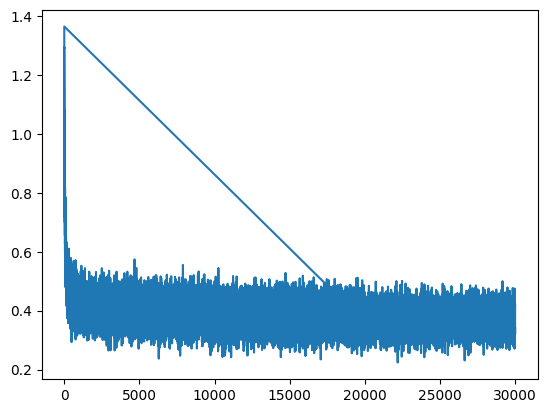

In [109]:
plt.plot(stepi, lossi)

In [110]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
trloss = F.cross_entropy(logits, Ytr)
print("TRAINING LOSS: ", trloss.item())

emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
devloss = F.cross_entropy(logits, Ydev)
print("DEV LOSS: ", devloss.item())

TRAINING LOSS:  2.367455005645752
DEV LOSS:  2.3685367107391357


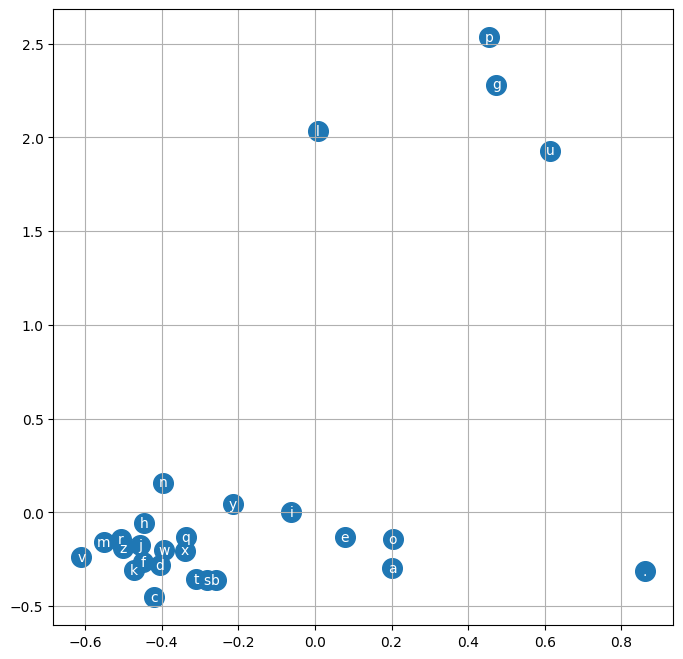

In [111]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [112]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carpah.
ami.
havi.
kimri.
rehty.
sranden.
jaronte.
dherart.
kaqei.
nerania.
chaiiv.
kaleig.
dham.
join.
qainn.
sroilea.
jadbi.
watelo.
dearyxi.
jacen.


# Let's Increase The Size of The Model
We are not overfitting, the proof is that training loss and dev loss is about the same.

In [113]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [114]:
HIDDEN_LAYER_SIZE = 300

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, HIDDEN_LAYER_SIZE), generator=g)
b1 = torch.randn(HIDDEN_LAYER_SIZE, generator=g)
W2 = torch.randn((HIDDEN_LAYER_SIZE, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

for i in range(60000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32,100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 20000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

In [115]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
trloss = F.cross_entropy(logits, Ytr)
print("TRAINING LOSS: ", trloss.item())

emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
devloss = F.cross_entropy(logits, Ydev)
print("DEV LOSS: ", devloss.item())

TRAINING LOSS:  2.318276882171631
DEV LOSS:  2.319495439529419


In [116]:
# Batch size is too low, so we are thrashing too much
# Training time was too low because we have more parameters
# Another issue is our embedding dimension is only 2

In [117]:
HIDDEN_LAYER_SIZE = 300
VOCAB_DIMENSION = 10

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, VOCAB_DIMENSION), generator=g)
W1 = torch.randn((VOCAB_DIMENSION * 3, HIDDEN_LAYER_SIZE), generator=g)
b1 = torch.randn(HIDDEN_LAYER_SIZE, generator=g)
W2 = torch.randn((HIDDEN_LAYER_SIZE, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

for i in range(60000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, VOCAB_DIMENSION * 3) @ W1 + b1) # (32,100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 20000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

In [118]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, VOCAB_DIMENSION * 3) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
trloss = F.cross_entropy(logits, Ytr)
print("TRAINING LOSS: ", trloss.item())

emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, VOCAB_DIMENSION * 3) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
devloss = F.cross_entropy(logits, Ydev)
print("DEV LOSS: ", devloss.item())

TRAINING LOSS:  2.2466583251953125
DEV LOSS:  2.289618492126465


In [119]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carlah.
amelle.
khi.
mili.
thayvence.
saejanhute.
deerahtipaeli.
nertara.
chaiivia.
lege.
dham.
poli.
quint.
srline.
livabiur.
jero.
dearyni.
jaceelinsleee.
deci.
abetteley.


# Can you beat me?
Try it yourself, you can achieve lower error rates with:
1. num neruons
2. hidden layers size
3. embedding dimension
4. training steps
5. validation dataset size
6. learning rate
7. learning rate decay